## Assessment 2

Import Necessary Libraries


In [1]:
import tweepy
import json
import re
import collections

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

!pip -q install demoji
import demoji
demoji.download_codes()

from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings 
warnings.filterwarnings("ignore")

... OK (Got response in 0.37 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Import Credentials from tweet_creds.py


In [2]:
%run -i "tweet_creds.py"

Tweet Extraction Function
* extracts tweet per user
* identifies tweet with or without photo

In [3]:
def extract_tweet(name, maxi):     # tweet extraction function (inputs: screen_name and max. number of tweets)
  max_tweets = maxi
  screen_name = name
  
  tweets = api.user_timeline(screen_name = screen_name,
                           tweet_mode = 'extended',     # 280 character tweets
                           count = max_tweets)
  list_of_dicts = []     # tweet dictionary
  photo_list = []        # photo status list (yes/no)

  for json_tweet in tweets:
    list_of_dicts.append(json_tweet._json)
    for media in json_tweet.entities.get("media", [{}]):      # check tweet contains photos (yes/no)
      if media.get("type", None) == "photo":
        photo_list.append("Yes")             
      else:
        photo_list.append("No")

  with open('%s_tweets.json' % name, mode = 'w') as file:     # save tweet dictionary to csv
    file.write(json.dumps(list_of_dicts, indent = 4))
  
  with open("%s_photo.txt" % name, mode = 'w') as file:     # save photo list to csv
    file.write(json.dumps(photo_list))

In [4]:
user = ["KingJames", "Alison_McGovern"]     # twitter screen name
maxi = 200     # max number of tweets

for name in user:                 
  extract_tweet(name, maxi)     # tweet extraction function

Read tweets csv file per user, created by twitter extraction function.

In [5]:
dict_u1 = []     # user 1
dict_u2 = []     # user 2
cnt = 0     # counter

for name in user:
  if cnt == 0:
    with open('%s_tweets.json' % name, mode = 'r', encoding = 'utf-8') as file:     # user 1
      dict_u1 = (json.load(file))
    cnt = cnt + 1
  else:
     with open('%s_tweets.json' % name, mode = 'r', encoding = 'utf-8') as file:    # user 2
       dict_u2 = (json.load(file))

Fetch needed twitter information for analysis.

In [6]:
dict_arr = [dict_u1, dict_u2]
tweet_list = []

for dct in dict_arr:
  for tweet in dct:
    list_per_tweet = []
    text = tweet["full_text"]            # extended tweet text
    created_at = tweet["created_at"]     # datetime
    source = tweet["source"]             # iphone / android
    user = tweet["user"]["screen_name"]  # twitter username
    list_per_tweet.extend((user, text, created_at, source))
    tweet_list.append(list_per_tweet)    # store all variables above in tweet_list list

Store tweet information to a Data Frame

In [7]:
tweet_df = pd.DataFrame(tweet_list, columns = ["screen_name", "text", "created_at", "source"])

source_list = tweet_df["source"].tolist()
os_list = []
for tweet in source_list:
  boo = "iPhone" in tweet
  if boo == True:
    os_list.append("iPhone")
  else:
    os_list.append("Android")

tweet_df["source"] = os_list
tweet_df["created_at"] = pd.to_datetime(tweet_df["created_at"])

### Percentage of Tweet per Hour, per Source
* Alison McGovern uses Android, while Lebron James uses Iphone

### Observations
Android
* The android user's highest tweet percentage is between approximately 10AM to 1PM UTC(+00:00), or 11AM to 2PM UTC(+01:00) for UK daylight saving timezone. 
* Android user is mostly active on twitter between approximately 5AM to 9PM UTC(+00:00), or 6AM to 10PM UTC(+01:00).  

IPhone 
* The Iphone user's highet tweet percentage is between approximately 2PM to 6PM UTC(+00:00), or 10AM to 2PM UTC(-04:00) for Florida, USA, which the current location of the user. 
* The IPhone user is mostly active between approximately 2PM to 5AM UTC(+00:00), or 10AM to 1AM UTC(-04:00).

### Analysis
* It can be concluded that both users are active during lunch time, and is most likely to be free during these hours.
* The time the users' sleep and wake-up time/hours can be hypothesized with the their tweet line graph. That Android user (Alison McGovern) sleeps after 10PM UTC(+01:00), and wakes up before 6AM UTC(+01:00). While, IPhone user (Lebron James) sleeps after 1AM UTC(-04:00), and wakes up before 10AM UTC(-04:00).

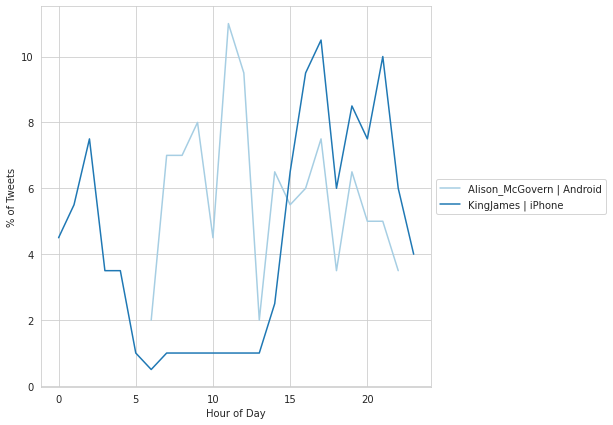

In [8]:
hour_list = []

for h in tweet_df["created_at"]:
  hour_list.append(h.hour)

tweet_df["user_source"] = tweet_df["screen_name"].map(str) + " | " + tweet_df["source"].map(str)
tweet_df["hour"] = hour_list
fig1_data = tweet_df.groupby("user_source")["hour"].value_counts().sort_index()
fig1_data = fig1_data.reset_index(level = 'user_source')
fig1_data.index.name = "time_hours"
fig1_data.columns = ["user_source", "count_hours"]

hour_list = []
for p in fig1_data["count_hours"]:
  hour_list.append((p/200)*100)
fig1_data["count_hours"] = hour_list

plt.figure(figsize = (7, 7))
sns.set_style("whitegrid")
ax = sns.lineplot(data = fig1_data, x = "time_hours", y = "count_hours", hue = "user_source", palette = "Paired")
ax.set(xlabel = "Hour of Day", ylabel = "% of Tweets")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

### Tweet Status per User
* Approximately 62.5% of Alison McGovern's tweets are retweets.
* While, 85% of Lebron Jame's tweets are original tweets.


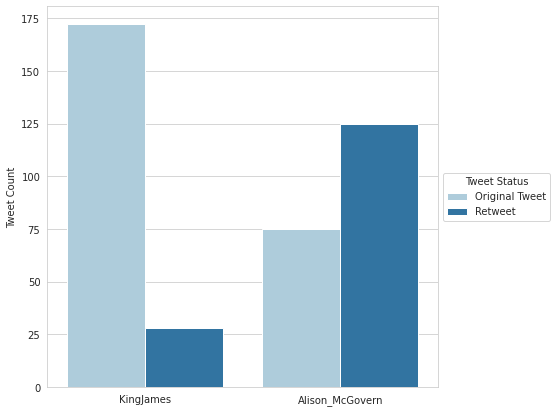

In [9]:
RT = tweet_df.text.str.startswith("RT").to_list()     # outputs True if both conditions are met
tweet_df["RT"] = RT
tweet_df["RT"] = tweet_df["RT"].replace(True,"Retweet")     # rename media column boolean values
tweet_df["RT"] = tweet_df["RT"].replace(False,"Original Tweet")

plt.figure(figsize = (7, 7))
sns.set_style("whitegrid")
ax = sns.countplot(x = "screen_name", hue = "RT", data = tweet_df, palette="Paired")
ax.set(xlabel="", ylabel = "Tweet Count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title = "Tweet Status")     # fix legend

Add column with_photos in Data Frame, which indicates if the tweet contains any photo/image.

In [10]:
user = ["KingJames", "Alison_McGovern"]
img_u1 = []
img_u2 = []
cnt = 0

for name in user:
  if cnt == 0:
    with open('%s_photo.txt' % name, mode = 'r', encoding = 'utf-8') as file:     # read photo list text file user 1
      img_u1 = (json.load(file))
    cnt = cnt + 1
  else:
     with open('%s_photo.txt' % name, mode = 'r', encoding = 'utf-8') as file:    # read photo list text file user 2
       img_u2 = (json.load(file))

img_df = pd.DataFrame(img_u1, columns=["with_photo"])     # add photo status to Data Frame
img_df = img_df.append(pd.DataFrame(img_u2, columns=["with_photo"]), ignore_index = True)
tweet_df = pd.concat([tweet_df, img_df], axis = 1)

Checks if tweets contain any URL, and write URL status to Data Frame on column with_URL

In [11]:
text_list = tweet_df["text"].tolist()
url_list = []

for tweet in text_list:
  url = re.findall(r'https?:\/\/.*[\r\n]*', tweet)     # regex pattern of URL
  if not url:
    url_list.append("No")
  else:
    url_list.append("Yes")

tweet_df["with_url"] = url_list     # write URL status to Data Frame

Remove retweet for both users from the DataFrame

In [12]:
tweet_df = tweet_df[~tweet_df["text"].str.startswith('RT')]
text_list = tweet_df["text"].tolist()

### Tweets with/without photo or URL, per User
* Most of the tweets does not contain any image or URL, for both users, and has a huge difference in the number of tweets with media tags or URL, and without.
* With regards to the number of tweets with photo or URL, Lebron James has higher number of tweets with these media tags compared to Alison McGovern. 
* Due to original tweets are only considered in this analysis, 37.5% of Alison McGovern's tweets are counted. Hence, Lebron James has higher number of tweet without media tags compared to Alison McGovern.
* Considering the percentage of original tweets without media tags for both users, it ranges approximately 93% to 94% of their original tweets.

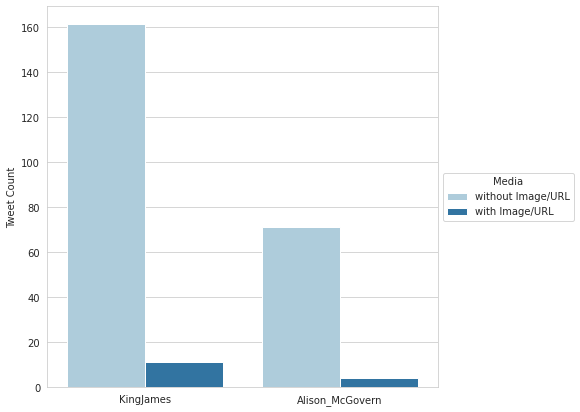

In [13]:
img_url = tweet_df.with_photo.str.contains("No") & tweet_df.with_photo.str.contains("No").to_list()     # outputs True if both conditions are met
tweet_df["media"] = img_url
tweet_df["media"] = tweet_df["media"].replace(True,"without Image/URL")     # rename media column boolean values
tweet_df["media"] = tweet_df["media"].replace(False,"with Image/URL")

plt.figure(figsize = (7, 7))
sns.set_style("whitegrid")
ax = sns.countplot(x = "screen_name", hue = "media", data = tweet_df, palette="Paired")
ax.set(xlabel="", ylabel = "Tweet Count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title = "Media")     # fix legend

### Number of Hashtags per Tweet, per User
* Approximately 80% of Alison McGovern's original tweets has no hashtag, while approximately 70% of Lebron James's original tweet has no hashtag. Lebron James uses hashtags more often than Alison McGovern based on the histogram.
* Lebron James uses 3 hashtags maximum in a tweet, while Alison McGovern uses a maximum of 4 hashtags a tweet. The number of tweets decreases as the number of hashtags increases for both users.
* Lebron James has higher number of original tweets with 1 upto 3 hashtags a tweet compared to Alison McGovern. But Alison McGovern uses upto 4 hashtags a tweet, unlike Lebron James.

[Text(0, 0.5, 'Number of Tweets'),
 Text(0.5, 0, 'Number of Hashtags per Tweet')]

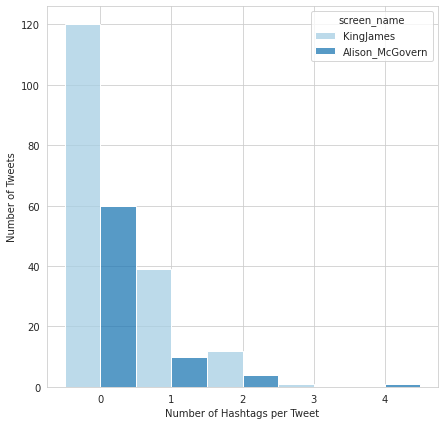

In [14]:
hash_list = []

for tweet in text_list:
  hash = re.findall(r'#(\w+)', tweet)     # regex pattern for hashtag in a tweet
  hash_list.append(len(hash))             # count hashtags found in a tweet

tweet_df["hashtag"] = hash_list

plt.figure(figsize = (7, 7))
ax = sns.histplot(tweet_df, x = "hashtag", hue = "screen_name", multiple="dodge", discrete = True, palette = "Paired")
ax.set(xlabel = "Number of Hashtags per Tweet", ylabel = "Number of Tweets")

Tweet Cleaning:
* removed URL
* removed emoji
* removed stop words using NLTK
* removed "rt"
* tokenized words were tranformed to lowercase and lemmatize, stored into a list and tallied.

In [15]:
user = ["KingJames", "Alison_McGovern"]
cnt = 0
raw_text_list = []

for tweet in text_list:
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags = re.MULTILINE)     # remove URL
  tweet = demoji.replace(tweet, "")                                            # remove emoji
  raw_text_list.append(re.sub(r"[^a-zA-Z0-9#@\']+", ' ', tweet))                    # append clean tweets, without numbers, # amd @

tweet_df["raw_text"] = raw_text_list                                           # add clean tweet to Data Frama

def token_clean(list):
  token_list = [regexp_tokenize(tweet, "[\w^a-zA-Z0-9#@\']+") for tweet in list]     # tokenize tweets
  token_list = [word.lower() for sublist in token_list for word in sublist]
  cachedStopWords = set(stopwords.words("english"))                                  # remove stop words
  lm = WordNetLemmatizer()
  remove_stop_list =  [lm.lemmatize(word) for word in token_list if not word in cachedStopWords]
  retweet = ["rt", "rts", "retweet"]                                                 # remove retweet indicators
  clean_list =  [word for word in remove_stop_list if not word in retweet]
  return clean_list

for name in user:     # tally clean tokenized words
  if cnt == 0:
    raw_list_u1 = tweet_df["raw_text"].loc[tweet_df["screen_name"] == name].to_list()
    clean_list_u1 = token_clean(raw_list_u1)
    word_cnt_u1 = collections.Counter(clean_list_u1)
    cnt = cnt + 1
  else:
    raw_list_u2 = tweet_df["raw_text"].loc[tweet_df["screen_name"] == name].to_list()
    clean_list_u2 = token_clean(raw_list_u2)
    word_cnt_u2 = collections.Counter(clean_list_u2)

Store word and word count data per user in separate data frame per user.
Removed hashtags and mentions in the data frames, then combine the two data frames to new data frame.

In [16]:
wcu1_df = pd.DataFrame.from_dict(word_cnt_u1, orient = 'index').sort_values(0, ascending = False).reset_index()     # user 1
wcu1_df.columns = ["words", "counts"]
wcu1_df["screen_name"] = "KingJames"

mention_u1 = wcu1_df[wcu1_df.words.str.contains("@", regex=False)]
hash_u1 = wcu1_df[wcu1_df.words.str.contains("#", regex=False)]

wcu1_df = wcu1_df[~wcu1_df.words.str.contains("#", regex=False)]
wcu1_df = wcu1_df[~wcu1_df.words.str.contains("@", regex=False)]

wcu2_df = pd.DataFrame.from_dict(word_cnt_u2, orient = 'index').sort_values(0, ascending = False).reset_index()     # user 2
wcu2_df.columns = ["words", "counts"]
wcu2_df["screen_name"] = "Alison_McGovern"

mention_u2 = wcu2_df[wcu2_df.words.str.contains("@", regex=False)]
hash_u2 = wcu2_df[wcu2_df.words.str.contains("#", regex=False)]

wcu2_df = wcu2_df[~wcu2_df.words.str.contains("#", regex=False)]
wcu2_df = wcu2_df[~wcu2_df.words.str.contains("@", regex=False)]

top_df = pd.concat([wcu1_df, wcu2_df]).reset_index()     # concatenate user1 df and user2 df
top_df = top_df.drop(columns = ["index"])

Compute the log odds ratio of words (including hashtags and mentions), per user.

In [17]:
total_cnt = []
cnt = 0
while cnt != 2:
  total_cnt.append(top_df.groupby("screen_name")["counts"].sum()[cnt])
  cnt = cnt + 1

log_odds = []
for word in wcu1_df["words"]:
  if word not in wcu2_df.values:
    u2_count = 0
  else:
    u2_count = wcu2_df[wcu2_df.words == word].counts.item()
  u1_count = wcu1_df[wcu1_df.words == word].counts.item()
  log_odds.append(np.log2(((u1_count + 1)/(total_cnt[0] + 1))/((u2_count + 1)/(total_cnt[1] + 1))))
for word in wcu2_df["words"]:
  if word not in wcu1_df.values:
    u1_count = 0
  else:
    u1_count = wcu1_df[wcu1_df.words == word].counts.item()
  u2_count = wcu2_df[wcu2_df.words == word].counts.item()
  log_odds.append(np.log2(((u2_count + 1)/(total_cnt[1] + 1))/((u1_count + 1)/(total_cnt[0] + 1))))
top_df["log_odds"] = log_odds

Lebron James hashtags Word Cloud
* most of the hashtags used by Lebron James are elections related and aligned with the Black Lives Matter movement.

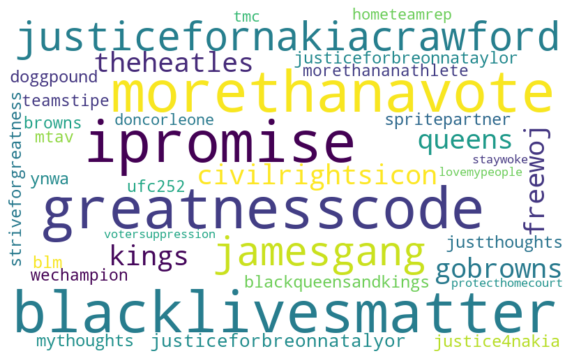

In [18]:
words= " ".join(hash_u1["words"])
wordcloud = WordCloud(width = 800, height = 500, random_state=21, max_font_size=110, background_color="white").generate(words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Alison McGovern hashtags Word Cloud
* hashtags related to the latest issues in the society, empowering women in sports, politics, are mostly used by Alison McGovern.

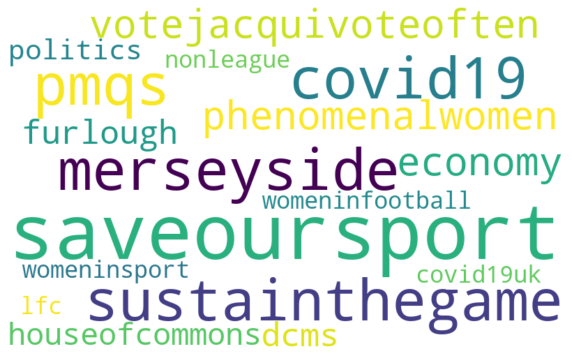

In [19]:
words= " ".join(hash_u2["words"])
wordcloud = WordCloud(width = 800, height = 500, random_state=21, max_font_size=110, background_color="white").generate(words)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

Top 20 Words with the highest Log Odds Ratio, per User
* It is observed that government/political related words most likely to belong to Alison McGovern. 
* While election related words, and words related to the black lives matter movement, most likely related to belong to Lebron James, in reference to Lebron's Word Cloud.
* Since most of Alison McGovern's tweets are retweets, more than half of her tweets were removed, hence the log odds ratio of her used words are lower compared to Lebron James's log odd ratio of words used.

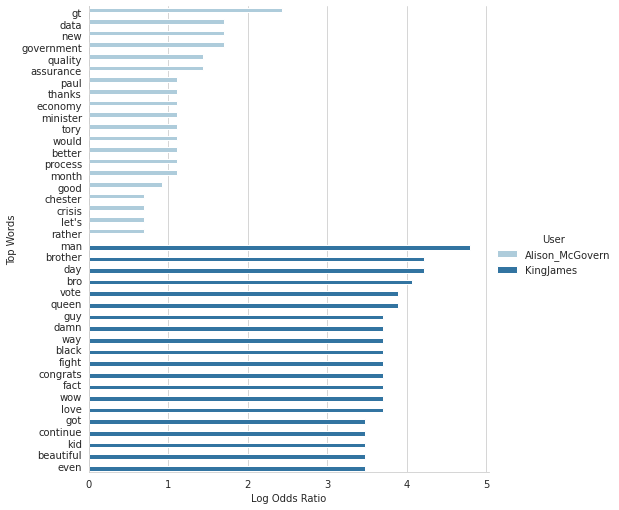

In [20]:
top_odds = top_df.groupby("screen_name").apply(lambda odds: odds.sort_values("log_odds", ascending = False))
top_odds = top_odds.reset_index(drop=True)
top_odds = top_odds.groupby("screen_name").head(20)
top_odds = top_odds.reset_index(drop = True)

sns.set_style("whitegrid")
ax = sns.catplot(x = "log_odds", y = "words", hue = "screen_name", data = top_odds, kind = "bar", orient = "h", palette = "Paired", height = 7)
ax.set(xlabel="Log Odds Ratio", ylabel = "Top Words")
ax._legend.set_title("User")

### Sentiment Analysis of Tweets per User
* based on the analysis of tweets, both users tweet mostly positive things, compared to tweets with negative sentiment.
* Approximately 82% of Lebron's original tweets have positive sentiment, while 73% of Alison's tweets have positive sentiment.


Source Code:
https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

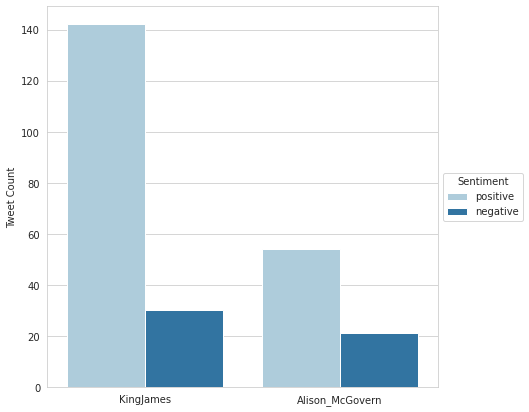

In [21]:
sid = SentimentIntensityAnalyzer()

tweet_df["scores"] = tweet_df["text"].apply(lambda tweet: sid.polarity_scores(tweet))
tweet_df["compound"] = tweet_df["scores"].apply(lambda score: score["compound"])
tweet_df["sentiment"] = tweet_df["compound"].apply(lambda comp: "positive" if comp >= 0 else "negative")

plt.figure(figsize = (7, 7))
ax = sns.countplot(x = "screen_name", hue = "sentiment", data = tweet_df, palette="Paired")
ax.set(xlabel="", ylabel = "Tweet Count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title = "Sentiment")

### Average Compound Score per User
* Lebron James has higher compound score compared to Alison McGovern, which denotes higher positive sentiment of his tweets compared to Alison's original tweets. This is also expected, in reference to the bar graph of sentiment analysis above.
* The average of compound scores for both users indicates positive sentiment, due to compound scores $\ge$ 0.05.

(Score Interpretation Reference: https://github.com/cjhutto/vaderSentiment#about-the-scoring)

In [22]:
comp_ave_df = tweet_df.groupby("screen_name")["compound"].mean()
comp_ave_df = comp_ave_df.to_frame()
comp_ave_df

,compound
screen_name,
Alison_McGovern,0.141416
KingJames,0.203006


In [23]:
tweet_df[tweet_df["screen_name"]=="KingJames"].to_csv('KingJames_tweet.csv',header=True, index=False)
tweet_df[tweet_df["screen_name"]=="Alison_McGovern"].to_csv('Alison_McGovern_tweet.csv',header=True, index=False)

Submitted by: Alyssa Lim (45799857)